In [1]:
# thresholding function of S(x)=|x|
soft_thres(x, λ) = max(x - λ, 0) - max(-x - λ, 0)
soft_nonneg_thres(x, λ) = max(x - λ, 0) # relu(x-λ)

soft_nonneg_thres (generic function with 1 method)

次に$\Theta_\lambda(\cdot)$を描画すると次のようになる．

In [2]:
using MAT
using PyPlot, LinearAlgebra

In [3]:
# datasets from http://www.rctn.org/bruno/sparsenet/
mat_images_raw = matopen("../contents/_static/datasets/IMAGES_RAW.mat")
imgs_raw = read(mat_images_raw, "IMAGESr")

#mat_images = matopen("../contents/_static/datasets/IMAGES.mat")
#imgs = read(mat_images, "IMAGES")
imgs = read(mat_images_raw, "IMAGESr")

close(mat_images_raw)
#close(mat_images)

In [4]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using LinearAlgebra, Random, Statistics, ProgressMeter
Random.seed!(0)
rc("axes.spines", top=false, right=false)

モデルを定義する．

In [5]:
@kwdef struct OFParameter{FT}
    lr_r::FT = 1e-2 # learning rate of r
    lr_W::FT = 1e-2 # learning rate of W
    λ::FT = 5e-3 # regularization parameter
end

@kwdef mutable struct OlshausenField1996Model{FT}
    param::OFParameter = OFParameter{FT}()
    num_inputs::Int32
    num_units::Int32
    batch_size::Int32
    r::Array{FT} = zeros(batch_size, num_units) # activity of neurons
    W::Array{FT} = randn(num_inputs, num_units) .* sqrt(1/num_units)
    M::Array{FT} = randn(num_units, num_units) .* sqrt(1/num_units)
end

パラメータを更新する関数を定義する．今回はより生理学的に妥当にするため，軟判定非負閾値関数を用いる．

In [25]:
function updateOF!(variable::OlshausenField1996Model, param::OFParameter, inputs::Array, training::Bool)
    @unpack num_inputs, num_units, batch_size, r, W, M = variable
    @unpack lr_r, lr_W, λ = param

    # Updates                
    error = inputs * W - r * M
    #r_ = (1-lr_r)*r + lr_r .* error
    r_ = r +lr_r .* error

    #r[:, :] = soft_thres.(r_, λ)
    r[:, :] = soft_nonneg_thres.(r_, λ)

    if training 
        error = inputs * W - r * M
        dW = inputs' * r - W
        dM = r' * r - I
        W[:, :] += lr_W * dW
        M[:, :] += lr_W * dM
    end
    
    return error
end

updateOF! (generic function with 1 method)

行ごとに正規化する関数を定義する．

In [7]:
function normalize_rows(A::Array)
    return A ./ sqrt.(sum(A.^2, dims=1) .+ 1e-8)
end

normalize_rows (generic function with 1 method)

損失関数を定義する．

In [8]:
function calculate_total_error(error, r, λ)
    recon_error = mean(error.^2)
    sparsity_r = λ*mean(abs.(r)) 
    return recon_error + sparsity_r
end

calculate_total_error (generic function with 1 method)

シミュレーションを実行する関数を定義する．外側の`for loop`では画像パッチの作成と`r`の初期化を行う．内側の`for loop`では`r`が収束するまで更新を行い，収束したときに重み行列`W`を更新する．

In [28]:
function run_simulation(imgs, num_iter, nt_max, batch_size, sz, num_units, eps)
    H, W, num_images = size(imgs)
    num_inputs = sz^2

    model = OlshausenField1996Model{Float32}(num_inputs=num_inputs, num_units=num_units, batch_size=batch_size)
    errorarr = zeros(num_iter) # Vector to save errors    
    
    # Run simulation
    @showprogress "Computing..." for iter in 1:num_iter
        # Get the coordinates of the upper left corner of clopping image randomly.
        beginx = rand(1:W-sz, batch_size)
        beginy = rand(1:H-sz, batch_size)

        inputs = zeros(batch_size, num_inputs)  # Input image patches

        # Get images randomly
        for i in 1:batch_size        
            idx = rand(1:num_images)
            img = imgs[:, :, idx]
            clop = img[beginy[i]:beginy[i]+sz-1, beginx[i]:beginx[i]+sz-1][:]
            inputs[i, :] = 0.5*(clop .- mean(clop))
        end

        model.r = zeros(batch_size, num_units) # Reset r states
        model.W = normalize_rows(model.W)
        model.M= normalize_rows(model.M)
        
        # Normalize weights
        # Input image patches until latent variables are converged 
        r_tm1 = zeros(batch_size, num_units)  # set previous r (t minus 1)

        for t in 1:nt_max
            # Update r without update weights 
            error = updateOF!(model, model.param, inputs, false)

            dr = model.r - r_tm1 

            # Compute norm of r
            dr_norm = sqrt(sum(dr.^2)) / sqrt(sum(r_tm1.^2) + 1e-8)
            r_tm1 .= model.r # update r_tm1

            # Check convergence of r, then update weights
            if dr_norm < eps
                error = updateOF!(model, model.param, inputs, true)
                errorarr[iter] = calculate_total_error(error, model.r, model.param.λ) # Append errors
                break
            end

            # If failure to convergence, break and print error
            if t >= nt_max-1
                print("Error at patch:", iter, dr_norm)
                errorarr[iter] = calculate_total_error(error, model.r, model.param.λ) # Append errors
                break
            end
        end
        # Print moving average error
        if iter % 100 == 0
            moving_average_error = mean(errorarr[iter-99:iter])
            println("iter: ", iter, "/", num_iter, ", Moving average error:", moving_average_error)
        end
    end
    return model, errorarr
end

run_simulation (generic function with 1 method)

`r_tm1 .= model.r`の部分は，要素ごとのコピーを実行している．`r_tm1 = copy(model.r)`でもよいが，新たなメモリ割り当てが生じるので避けている．`@. r_tm1 = model.r`としてもよい．

### シミュレーションの実行

In [29]:
# Simulation constants
num_iter = 500 # number of iterations
nt_max = 1000 # Maximum number of simulation time
batch_size = 250 # Batch size

sz = 16 # image patch size
num_units = 100 # number of neurons (units)
eps = 1e-2 # small value which determines convergence

model, errorarr = run_simulation(imgs, num_iter, nt_max, batch_size, sz, num_units, eps);

Computing...  20%|████████                               |  ETA: 0:01:14

iter: 100/500, Moving average error:2.0193922673584166


Computing...  40%|████████████████                       |  ETA: 0:00:55

iter: 200/500, Moving average error:2.0803716649133652


Computing...  60%|████████████████████████               |  ETA: 0:00:36

iter: 300/500, Moving average error:2.135229543756871


Computing...  80%|████████████████████████████████       |  ETA: 0:00:18

iter: 400/500, Moving average error:2.1145101741228736


Computing... 100%|███████████████████████████████████████| Time: 0:01:32


iter: 500/500, Moving average error:2.048231024135626


### 訓練中の損失の描画
訓練中の損失の変化を描画してみよう．損失が低下し，学習が進行したことが分かる．

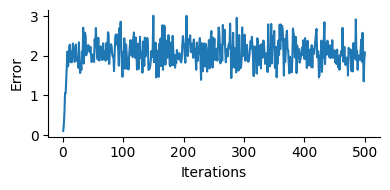

In [30]:
# Plot error
figure(figsize=(4, 2))
ylabel("Error")
xlabel("Iterations")
plot(1:num_iter, errorarr)
tight_layout()

### 重み行列 (受容野)の描画
学習後の重み行列 `W` ($\mathbf{\W}$)を可視化してみよう．

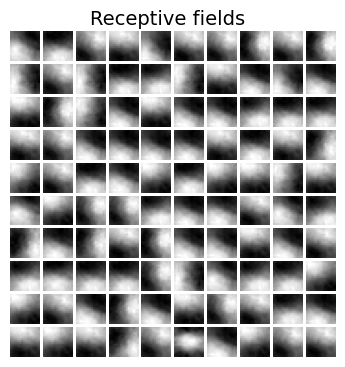

In [31]:
# Plot Receptive fields
figure(figsize=(4.2, 4))
subplots_adjust(hspace=0.1, wspace=0.1)
for i in 1:num_units
    subplot(10, 10, i)
    imshow(reshape(model.W[:, i], (sz, sz)), cmap="gray")
    axis("off")
end
suptitle("Receptive fields", fontsize=14)
subplots_adjust(top=0.925)

白色が**ON領域**(興奮)，黒色が**OFF領域**(抑制)を表す．Gaborフィルタ様の局所受容野が得られており，これは一次視覚野(V1)における単純型細胞(simple cells)の受容野に類似している．

### 画像の再構成
学習したモデルを用いて入力画像が再構成されるか確認しよう．

In [26]:
H, W, num_images = size(imgs)
num_inputs = sz^2

# Get the coordinates of the upper left corner of clopping image randomly.
beginx = rand(1:W-sz, batch_size)
beginy = rand(1:H-sz, batch_size)

inputs = zeros(batch_size, num_inputs)  # Input image patches

# Get images randomly
for i in 1:batch_size        
    idx = rand(1:num_images)
    img = imgs[:, :, idx]
    clop = img[beginy[i]:beginy[i]+sz-1, beginx[i]:beginx[i]+sz-1][:]
    inputs[i, :] = clop .- mean(clop)
end

model.r = zeros(batch_size, num_units) # Reset r states

# Input image patches until latent variables are converged 
r_tm1 = zeros(batch_size, num_units)  # set previous r (t minus 1)

for t in 1:nt_max
    # Update r without update weights 
    error = updateOF!(model, model.param, inputs, false)

    dr = model.r - r_tm1 

    # Compute norm of r
    dr_norm = sqrt(sum(dr.^2)) / sqrt(sum(r_tm1.^2) + 1e-8)
    r_tm1 .= model.r # update r_tm1

    # Check convergence of r, then update weights
    if dr_norm < eps
        break
    end
end;

神経活動 $\mathbf{r}$がスパースになっているか確認しよう．

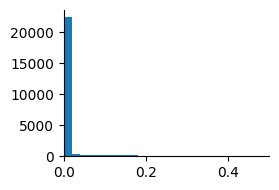

In [27]:
figure(figsize=(3, 2))
hist(model.r[:], bins=50)
xlim(0, 0.5)
tight_layout()

要素がほとんど0のスパースなベクトルになっていることがわかる．次に画像を再構成する．

In [28]:
reconst = model.r * model.W'
println(size(reconst))

(250, 256)


再構成した結果を描画する．

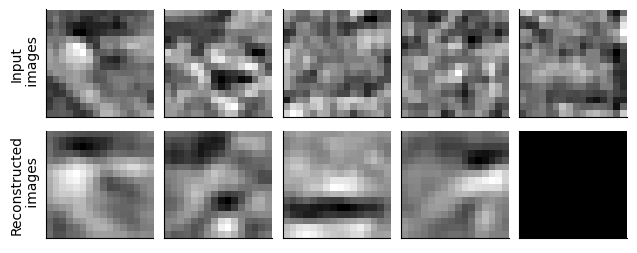

In [29]:
figure(figsize=(7.5, 3))
subplots_adjust(hspace=0.1, wspace=0.1)
num_show = 5
for i in 1:num_show
    subplot(2, num_show, i)
    imshow(reshape(inputs[i, :], (sz, sz)), cmap="gray")
    xticks([]); yticks([]); 
    if i == 1
        ylabel("Input\n images")
    end

    subplot(2, num_show, num_show+i)
    imshow(reshape(reconst[i, :], (sz, sz)), cmap="gray")
    xticks([]); yticks([]); 
    if i == 1
        ylabel("Reconstructed\n images")
    end
end

上段が入力画像，下段が再構成された画像である．差異はあるものの，概ね再構成されていることがわかる．

## 参考文献
```{bibliography}
:filter: docname in docnames
```

```{admonition} 論文以外の参考資料
- <http://www.scholarpedia.org/article/Sparse_coding>
- Bruno Olshausen: “Sparse coding in brains and machines”([Stanford talks](https://talks.stanford.edu/bruno-olshausen-sparse-coding-in-brains-and-machines/)), [Slide](http://www.rctn.org/bruno/public/Simons-sparse-coding.pdf)
- <https://redwood.berkeley.edu/wp-content/uploads/2018/08/sparse-coding-ICA.pdf>
- <https://redwood.berkeley.edu/wp-content/uploads/2018/08/sparse-coding-LCA.pdf>
- <https://redwood.berkeley.edu/wp-content/uploads/2018/08/Dylan-lca_overcompleteness_09-27-2018.pdf>
```